# Implementing physics from textbook "Physik mit Python"

# Ressources:
https://www.youtube.com/watch?v=7yZ5xxdkTb8

## 4.1 Inclined Throw

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

from Modules import MassPoint, PhysicsModel # import my own modules

In [4]:
# set initial values
h         = 10.0 # height [m]
v_ab      = 5.0  # initial velocity [m/s]
alpha_deg = 25.0 # throw angle in degrees
g         = 9.81 # earth gravity constant

In [6]:
def inclined_throw_fun(h, v_ab, alpha_deg, g):
    mp       = MassPoint(h, v_ab, alpha_deg)
    pmodel   = PhysicsModel(h, v_ab, alpha_deg, g)
    t_e      = pmodel.time_mp_hits_earth()
    t        = pmodel.make_time_points(0,t_e,1000)
    r        = pmodel.get_spacetime_vector_of_throw(time_points=t)
    dist     = r[-1,0]
    dist_inv = 1/dist
    return r, dist, dist_inv

In [8]:
def plot_spacetime_vector(spacetime_vector):    
    fig = plt.figure()
    ax  = fig.add_subplot(1,1,1)
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.grid()
    ax.plot(spacetime_vector[:,0], spacetime_vector[:,1])
    plt.show()

distance:  7.577527467920221


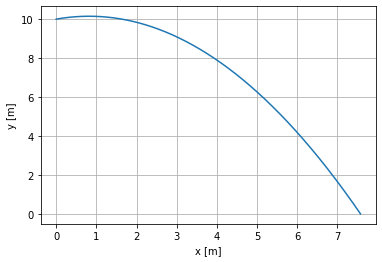

In [10]:
r, dist, dist_inv = inclined_throw_fun(h=h, v_ab=v_ab, alpha_deg=20.0, g=g)
print('distance: ', dist)
plot_spacetime_vector(spacetime_vector=r)

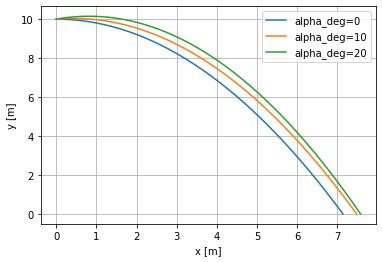

In [12]:
r1, _, _ = inclined_throw_fun(h=h, v_ab=v_ab, alpha_deg= 0.0, g=g)
r2, _, _ = inclined_throw_fun(h=h, v_ab=v_ab, alpha_deg=10.0, g=g)
r3, _, _ = inclined_throw_fun(h=h, v_ab=v_ab, alpha_deg=20.0, g=g)

# plot results
fig = plt.figure()
ax  = fig.add_subplot(1,1,1)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

ax.grid()
ax.plot(r1[:,0], r1[:,1])
ax.plot(r2[:,0], r2[:,1])
ax.plot(r3[:,0], r3[:,1])
ax.legend(['alpha_deg=0','alpha_deg=10','alpha_deg=20'])
plt.show()

# Optimization: Maximize the distance under variation of the angle 

In [14]:
_, _, dist_inv = inclined_throw_fun(h=h, v_ab=v_ab, alpha_deg=alpha_deg, g=g)
print(dist_inv)

0.13298508236677975


In [16]:
def objective_fun(x):
    h         = x[0]
    v_ab      = x[1]
    alpha_deg = x[2]
    g         = x[3]
    _, _, dist_inv = inclined_throw_fun(h=h, v_ab=v_ab, alpha_deg=alpha_deg, g=g)
    return (dist_inv - 0)**2      

In [18]:
def optimal_angle_given_height(lb=[h, v_ab, -89.0, g], ub=[h, v_ab, 89.0, g]):
    bounds    = Bounds(lb=lb, ub=ub)
    params    = [h, v_ab, alpha_deg, g]
    res       = minimize(objective_fun, 
                         params, 
                         method = 'trust-constr', 
                         bounds = bounds)
    optimal_angle = res['constr'][0][2]
    print('The optimal angle is {:0.1f} degrees.'.format(optimal_angle))
    return optimal_angle

In [20]:
optimal_angle_given_height(lb=[h, v_ab, -89.0, g], ub=[h, v_ab, 89.0, g])

The optimal angle is 18.6 degrees.


18.58188529952592

In [22]:
optimal_angle_list = [optimal_angle_given_height(lb=[h, v_ab, -89.0, g], ub=[h, v_ab, 89.0, g]) for h in range(0, 100)]

The optimal angle is 45.0 degrees.
The optimal angle is 36.8 degrees.
The optimal angle is 32.0 degrees.
The optimal angle is 28.6 degrees.
The optimal angle is 26.2 degrees.
The optimal angle is 24.3 degrees.
The optimal angle is 22.7 degrees.
The optimal angle is 21.4 degrees.
The optimal angle is 20.3 degrees.
The optimal angle is 19.4 degrees.
The optimal angle is 18.6 degrees.
The optimal angle is 17.9 degrees.
The optimal angle is 17.2 degrees.
The optimal angle is 16.6 degrees.
The optimal angle is 16.1 degrees.
The optimal angle is 15.6 degrees.
The optimal angle is 15.2 degrees.
The optimal angle is 14.8 degrees.
The optimal angle is 14.4 degrees.
The optimal angle is 14.1 degrees.
The optimal angle is 13.8 degrees.
The optimal angle is 13.5 degrees.
The optimal angle is 13.2 degrees.
The optimal angle is 12.9 degrees.
The optimal angle is 12.7 degrees.
The optimal angle is 12.4 degrees.
The optimal angle is 12.2 degrees.
The optimal angle is 12.0 degrees.
The optimal angle is

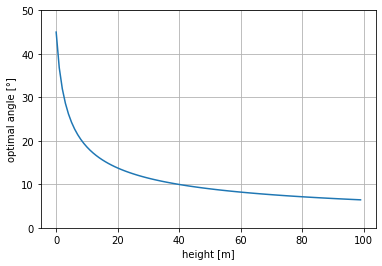

In [24]:
# plot results
fig = plt.figure()
ax  = fig.add_subplot(1,1,1)
ax.set_ylim(0,50)
ax.set_xlabel('height [m]')
ax.set_ylabel('optimal angle [°]')
ax.grid()
ax.plot(optimal_angle_list)
plt.show()

# Machine Learning Application

## Model the relationship between height, initial velocity, throwing angle and gravity constant as input parameters and the according distance as output parameter

### first of all simulate data for various combinations of these parameters

In [26]:
# loop over many possible combinations i.e. sample the parameter space as densely as possible

# save results in discitionary
data_dic = {}

counter = 0
for h in range(0,100,4):
    for v_ab in range(1,25,4):
        for alpha_deg in range(-90,90,4):
            for g in range(1,25,4): # ranging from moon to jupiter
                
                # calculate distance
                _, dist, _ = inclined_throw_fun(h=h, v_ab=v_ab, alpha_deg=alpha_deg, g=g)
                
                # save result
                data_dic[str(counter)] = [h, v_ab, alpha_deg, g, dist]
                
                # increase counter
                counter += 1

In [28]:
df = pd.DataFrame.from_dict(data_dic, orient='index', columns=['height', 'v_ab', 'alpha_deg', 'g', 'distance'])

In [30]:
df

,height,v_ab,alpha_deg,g,distance
0,0,1,-90,1,0.000000
1,0,1,-90,5,0.000000
2,0,1,-90,9,0.000000
3,0,1,-90,13,0.000000
4,0,1,-90,17,0.000000
...,...,...,...,...,...
40495,96,21,86,5,17.095249
40496,96,21,86,9,10.986372
40497,96,21,86,13,8.465141
40498,96,21,86,17,7.048680


### use neural network to predict the distance given the input parameters

In [32]:
# define features and targets
X = df[['height', 'v_ab', 'alpha_deg', 'g']]
y = df[['distance']].values.reshape(-1)

In [34]:
# split data for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

In [36]:
regr = MLPRegressor(hidden_layer_sizes = (20,10), 
                    random_state       = 1, 
                    max_iter           = 1000)

In [38]:
regr.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(20, 10), max_iter=1000, random_state=1)

In [40]:
regr.score(X_train, y_train)

0.9971660716659744

In [42]:
regr.score(X_test, y_test)

0.9971846402674319

In [44]:
y_pred = regr.predict(X_test)

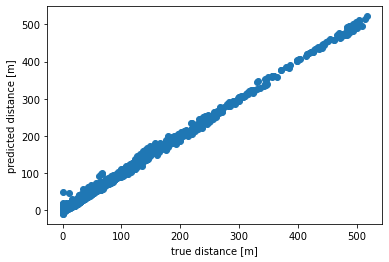

In [46]:
plt.scatter(y_test, y_pred)
plt.xlabel('true distance [m]')
plt.ylabel('predicted distance [m]')
plt.show()

In [48]:
def prep_input_nn(x):
    # proved a list of input variables
    return np.array([x])

In [50]:
def distance_fun_nn(x):
    # x must be in the form of x = array([[ 63,  19, -18,  10]]) --> use prep_input_nn(x)
    distance = regr.predict(x)
    return distance

In [52]:
def inverse_distance_fun_nn(x):
    # x must be in the form of x = array([[ 63,  19, -18,  10]]) --> use prep_input_nn(x)
    distance = regr.predict(x)
    return distance**(-1)

In [54]:
x_test = [ 63,  19, -18,  10]
x_test

[63, 19, -18, 10]

In [56]:
x = prep_input_nn(x_test)
x

array([[ 63,  19, -18,  10]])

In [58]:
distance_nn = distance_fun_nn(x)
print(distance_nn)

[53.88504702]


In [60]:
inverse_distance_nn = inverse_distance_fun_nn(x)
print(inverse_distance_nn)

[0.01855802]


In [62]:
def objective_fun_nn(x):
    # provide asset of parameter in a list x with: x = ['height', 'v_ab', 'alpha_deg', 'g'] 
    x = prep_input_nn(x)
    inverse_distance = inverse_distance_fun_nn(x)
    return (inverse_distance - 0)**2

In [64]:
x_test

[63, 19, -18, 10]

In [66]:
objective_fun_nn(x_test)

array([0.0003444])

In [68]:
def optimal_angle_given_height_nn(lb=[h, v_ab, -90.0, g], ub=[h, v_ab, 90.0, g]):
    bounds    = Bounds(lb=lb, ub=ub)
    params    = [h, v_ab, alpha_deg, g]
    res       = minimize(objective_fun_nn, 
                         params, 
                         method = 'trust-constr', 
                         bounds = bounds)
    optimal_angle = res['constr'][0][2]
    print('The optimal angle is {:0.1f} degrees.'.format(optimal_angle))
    return optimal_angle

In [70]:
optimal_angle_given_height_nn(lb=[h, v_ab, -90.0, g], ub=[h, v_ab, 90.0, g])

The optimal angle is 18.8 degrees.


18.800870654818365

In [72]:
optimal_angle_list_nn = [optimal_angle_given_height_nn(lb=[h, v_ab, -90.0, g], ub=[h, v_ab, 90.0, g]) for h in range(0, 100)]

The optimal angle is 61.0 degrees.
The optimal angle is 60.5 degrees.
The optimal angle is 60.0 degrees.
The optimal angle is 59.6 degrees.
The optimal angle is 59.1 degrees.
The optimal angle is 58.6 degrees.
The optimal angle is 58.1 degrees.
The optimal angle is 57.7 degrees.
The optimal angle is 57.2 degrees.
The optimal angle is 56.7 degrees.
The optimal angle is 56.2 degrees.
The optimal angle is 55.7 degrees.
The optimal angle is 55.3 degrees.
The optimal angle is 54.8 degrees.
The optimal angle is 54.3 degrees.
The optimal angle is 53.8 degrees.
The optimal angle is 53.3 degrees.
The optimal angle is 52.9 degrees.
The optimal angle is 52.4 degrees.
The optimal angle is 51.9 degrees.
The optimal angle is 51.4 degrees.
The optimal angle is 51.0 degrees.
The optimal angle is 50.5 degrees.
The optimal angle is 50.0 degrees.
The optimal angle is 15.3 degrees.
The optimal angle is 49.0 degrees.
The optimal angle is 48.6 degrees.
The optimal angle is 13.4 degrees.
The optimal angle is

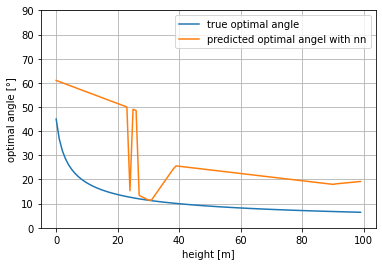

In [74]:
# plot results
fig = plt.figure()
ax  = fig.add_subplot(1,1,1)

ax.plot(optimal_angle_list)
ax.plot(optimal_angle_list_nn)

ax.set_ylim(0,90)
ax.set_xlabel('height [m]')
ax.set_ylabel('optimal angle [°]')
ax.legend(['true optimal angle','predicted optimal angel with nn'])
ax.grid()
plt.show()

In [76]:
# try brute force algorithm to find optimal angle using the NN since the gradient descent algo 
#probabliy doesent work since the curve is not smooth

In [78]:
# set initial values
h         = 10.0 # height [m]
v_ab      = 5.0  # initial velocity [m/s]
alpha_deg = 25.0 # throw angle in degrees
g         = 9.81 # earth gravity constant

In [80]:
data_dic = {}
counter = 0
for h in range(0,100,1):
    for alpha_deg in range(-90,90,1):
        # input values
        params = np.array([[h, v_ab, alpha_deg, g]])
        # calculate distance
        distance = distance_fun_nn(params)
        distance = np.round(distance[0],2)
        # save results
        data_dic[str(counter)] = [h, v_ab, alpha_deg, g, distance]
        # increase counter
        counter +=1
        
        #print('input parameters: ', params)
        #print('throw distance: ', distance)

In [82]:
df = pd.DataFrame.from_dict(data_dic, orient='index', columns=['height', 'v_ab', 'alpha_deg', 'g', 'distance'])

In [84]:
df.head()

,height,v_ab,alpha_deg,g,distance
0,0,5.0,-90,9.81,-2.30
1,0,5.0,-89,9.81,-2.03
2,0,5.0,-88,9.81,-1.96
3,0,5.0,-87,9.81,-1.89
4,0,5.0,-86,9.81,-1.82


In [86]:
distance  = df[df['height'] == 0]['distance']
alpha_deg = df[df['height'] == 0]['alpha_deg']

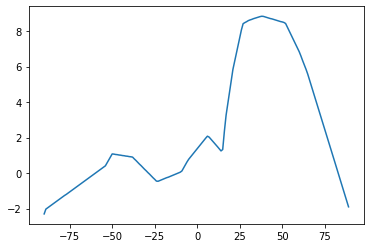

In [88]:
plt.plot(alpha_deg, distance)
plt.show()

In [90]:
h = 0
index = np.argmax(df[df['height'] == h]['distance'])
alpha_deg_opt = df[df['height'] == h].iloc[index,:]['alpha_deg']

print('height: ', h)
print('the optimal angle is: ', alpha_deg_opt)

height:  0
the optimal angle is:  38.0


In [92]:
for h in range(0,100):
    index = np.argmax(df[df['height'] == h]['distance'])
    alpha_deg_opt = df[df['height'] == h].iloc[index,:]['alpha_deg']

    print('height: ', h)
    print('the optimal angle is: ', alpha_deg_opt)
    

height:  0
the optimal angle is:  38.0
height:  1
the optimal angle is:  38.0
height:  2
the optimal angle is:  38.0
height:  3
the optimal angle is:  38.0
height:  4
the optimal angle is:  25.0
height:  5
the optimal angle is:  25.0
height:  6
the optimal angle is:  24.0
height:  7
the optimal angle is:  24.0
height:  8
the optimal angle is:  23.0
height:  9
the optimal angle is:  23.0
height:  10
the optimal angle is:  23.0
height:  11
the optimal angle is:  22.0
height:  12
the optimal angle is:  22.0
height:  13
the optimal angle is:  21.0
height:  14
the optimal angle is:  21.0
height:  15
the optimal angle is:  -3.0
height:  16
the optimal angle is:  -4.0
height:  17
the optimal angle is:  -5.0
height:  18
the optimal angle is:  -1.0
height:  19
the optimal angle is:  3.0
height:  20
the optimal angle is:  3.0
height:  21
the optimal angle is:  3.0
height:  22
the optimal angle is:  3.0
height:  23
the optimal angle is:  3.0
height:  24
the optimal angle is:  3.0
height:  25
the 

In [94]:
#test test

In [96]:
#

In [98]:
# To Do
# xxxxxx
# xxxxx
# https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html
